In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [6]:
import pickle

In [7]:
picklefile = open('data/headlines_with_location', 'rb')

In [8]:
#unpickle the dataframe
df = pickle.load(picklefile)

In [9]:
df.head()

,Headline,City,Country,Latitude,Longitude,Country Code
0,Zika Outbreak Hits Miami,Miami,None,25.77427,-80.19366,US
1,Could Zika Reach New York City?,New York City,None,40.71427,-74.00597,US
2,First Case of Zika in Miami Beach,Miami Beach,None,25.79065,-80.13005,US
3,"Mystery Virus Spreads in Recife, Brazil",Recife,Brazil,-8.05389,-34.88111,BR
4,Dallas man comes down with case of Zika,Dallas,None,32.78306,-96.80667,US


In [10]:

#Clean up the NaN from coordinates dataset so that the SK learn modeling will be happy
coords_clean = df[["Longitude", "Latitude"]].dropna()

In [12]:
print(f"After dropping NaN values, {np.shape(coords_clean)[0]} rows remaining")

After dropping NaN values, 609 rows remaining


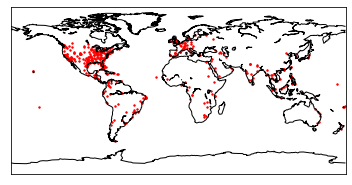

In [13]:
map = Basemap()
map.drawcoastlines()

x, y = map(coords_clean['Longitude'].to_list(),coords_clean['Latitude'].to_list())
map.scatter(x, y, marker='o', color = 'r', s = 2, latlon=True)

plt.rcParams['figure.dpi'] = 150 # default for me was 75
plt.show()

In [14]:
df[(df['Longitude'] < -148) & (df['Longitude'] > -152)]

,Headline,City,Country,Latitude,Longitude,Country Code
348,Lower Hospitalization in Papeete after Measles...,Papeete,None,-17.53733,-149.5665,PF


In [15]:
(df[['Latitude','Longitude']][df['Latitude'].isna() | df['Longitude'].isna()].dropna()).shape

(0, 2)

In [16]:
def visualize(coords, colors, dpi = 200):
    '''visualize coords, a DataFrame with columns Longitude, Latitude, and Cluster '''
    map = Basemap()

    map.drawmapboundary()
    map.drawcoastlines()
    
    #translate clusters into colors
    colors = [colors[cluster] for cluster in coords['K-means'] ]
    
    x, y = map(coords['Longitude'].to_list(),coords['Latitude'].to_list())
    
    map.scatter(x, y, marker='o', c = colors, s = 2)
    
    plt.rcParams['figure.dpi'] = dpi # default for me was 75
    plt.show()

In [17]:
def run_kmeans(coords, num_clusters):

    #Run the model
    cluster_model = KMeans(n_clusters = num_clusters)
    assignments = cluster_model.fit_predict(coords)
    
    coords['K-means'] = assignments
    
    return(coords)

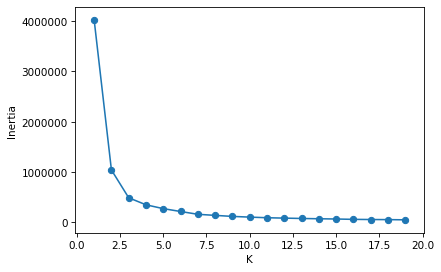

In [18]:

#Generate inertia data so that we can generate an inertia plot
k_values = range(1, 20)
inertia_values = [KMeans(k).fit(coords_clean).inertia_ for k in k_values]

plt.rcParams['figure.dpi'] = 75 # default for me was 75
plt.plot(k_values, inertia_values)
plt.scatter(k_values, inertia_values)
plt.xlabel("K")
plt.ylabel("Inertia")
plt.show()

In [19]:
#Generate a color map from some default available color maps

from matplotlib.cm import get_cmap
name = "Set1"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors   # type: list
print(f"Generated {len(colors)} colors from colormap {name}")
map_colors = [colors[cluster] for cluster in range(len(colors))]

Generated 9 colors from colormap Set1


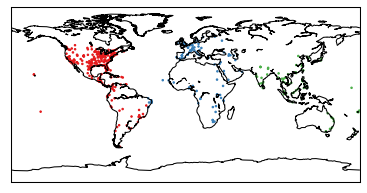

In [20]:
num_clusters = 3
coords_kmeans_3 = run_kmeans(coords_clean, num_clusters)
visualize(coords_kmeans_3, map_colors, dpi = 200)

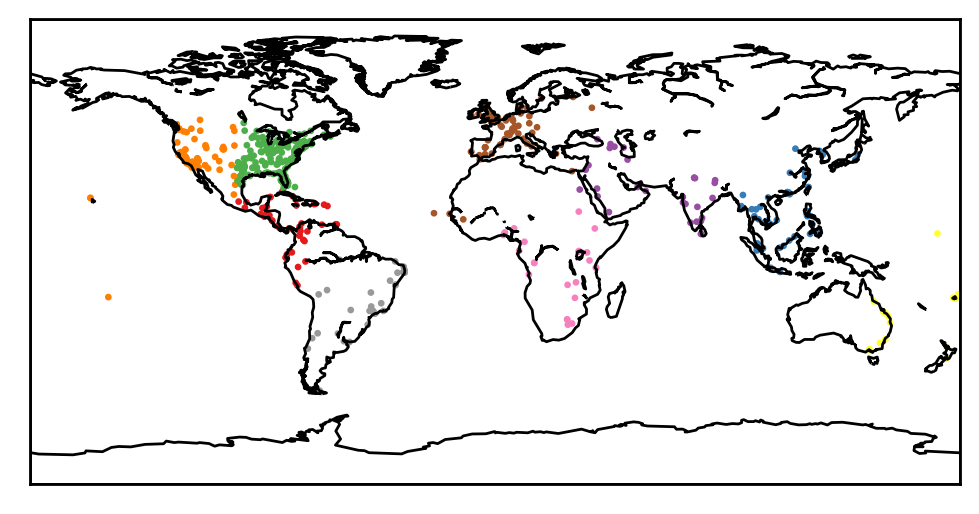

In [21]:

num_clusters = 9
coords_kmeans_9 = run_kmeans(coords_clean, num_clusters)
visualize(coords_kmeans_9, map_colors, dpi = 200)

In [22]:
num_clusters = 20
coords_kmeans_20 = run_kmeans(coords_clean, num_clusters)

In [23]:
#Generate a color map from some default available color maps

from matplotlib.cm import get_cmap
name1 = "tab20b"
default_color = 'w'
cmap1 = get_cmap(name1)  # type: matplotlib.colors.ListedColormap
colors = cmap1.colors  # type: list

print(f"Generated {len(colors)} colors from colormaps {name1}")
map_colors = [colors[cluster] if cluster != -1 else default_color for cluster in coords_kmeans_20['K-means']]

Generated 20 colors from colormaps tab20b


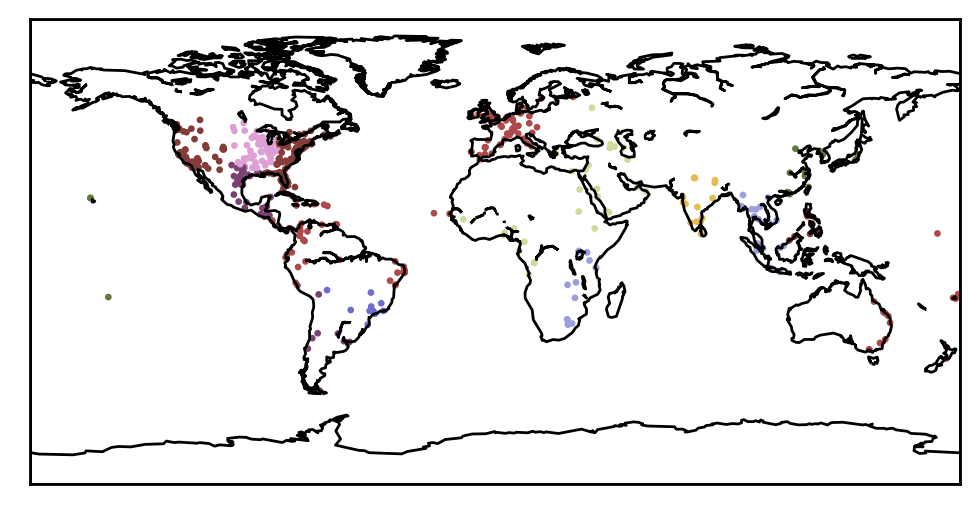

In [24]:
visualize(coords_kmeans_20, map_colors, dpi = 200)

In [26]:
def visualize_clusters(coords, color, dpi = 200):
    '''visualize coords, a DataFrame with columns Longitude, Latitude, and Cluster '''
    map = Basemap()

    map.shadedrelief()

    x, y = map(coords['Longitude'].to_list(),coords['Latitude'].to_list())
    map.scatter(x, y, marker='o', c = color, s = 1.5)
    
    plt.rcParams['figure.dpi'] = dpi # default for me was 75
    plt.show()

In [27]:

def run_dbscan(coords, epsilon = 5, min_points = 5):
    cluster_model = DBSCAN(eps=epsilon, min_samples=min_points)
    disease_clusters = cluster_model.fit_predict(coords)
    coords['DBSCAN'] = disease_clusters
    num_clusters = np.unique(disease_clusters)
    
    assert disease_clusters.shape[0] == coords.shape[0]
    
    return(coords, num_clusters)

In [28]:
coords_dbscan, num_clusters = run_dbscan(coords_clean, epsilon = 5.5, min_points = 3)
print(f"The clustering created {len(num_clusters)-1} clusters.")

The clustering created 28 clusters.


In [29]:
coords_dbscan.head()

,Longitude,Latitude,K-means,DBSCAN
0,-80.19366,25.77427,13,0
1,-74.00597,40.71427,10,0
2,-80.13005,25.79065,13,0
3,-34.88111,-8.05389,19,1
4,-96.80667,32.78306,12,0


In [30]:
#Generate a color map from some default available color maps

from matplotlib.cm import get_cmap
name2 = "tab20b"
name1 = "tab20"
default_color = 'w'
cmap1 = get_cmap(name1)  # type: matplotlib.colors.ListedColormap
cmap2 = get_cmap(name2)
colors = cmap1.colors + cmap2.colors  # type: list
print(f"Generated {len(colors)} colors from colormaps {name1} and {name2}")
map_colors = [colors[cluster] if cluster != -1 else default_color for cluster in coords_dbscan['DBSCAN']]

Generated 40 colors from colormaps tab20 and tab20b


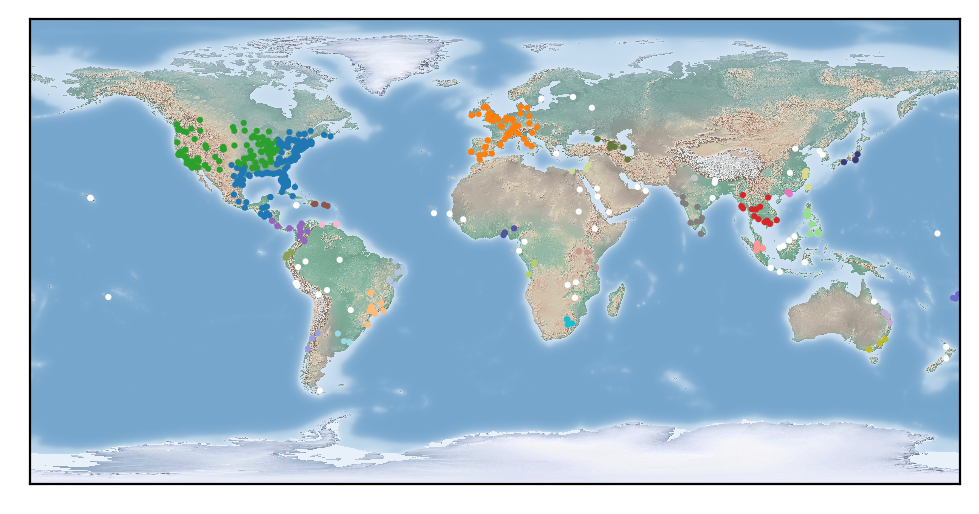

In [31]:

visualize_clusters(coords_dbscan, map_colors)

In [32]:
result = pd.concat([df, coords_dbscan[['K-means','DBSCAN']]], axis = 1)

In [33]:

result.head()

,Headline,City,Country,Latitude,Longitude,Country Code,K-means,DBSCAN
0,Zika Outbreak Hits Miami,Miami,None,25.77427,-80.19366,US,13.0,0.0
1,Could Zika Reach New York City?,New York City,None,40.71427,-74.00597,US,10.0,0.0
2,First Case of Zika in Miami Beach,Miami Beach,None,25.79065,-80.13005,US,13.0,0.0
3,"Mystery Virus Spreads in Recife, Brazil",Recife,Brazil,-8.05389,-34.88111,BR,19.0,1.0
4,Dallas man comes down with case of Zika,Dallas,None,32.78306,-96.80667,US,12.0,0.0


In [34]:
result.to_pickle('./data/headlines_clustered.pkl')